To see the latest numbers please use **Ctrl + F5** or **Shift + F5**

**S1 : Puddled Transplanted**<br> 
**S2 : Mechanical Transplanted**<br> 
**S3 : DSR**<br> 
**S4 : DSR**

**Conditions for the irrigation recommendation :**<br> 
* Full Irrigation plots :<br>
    * Recommendation Criteria:<br> 
        * If there are three consecutive 0 readings in the Paani Pipe readings, irrigation is recommended.<br>
* Farmer Irrigation plots :<br> 
    * Recommendation Criteria:<br>
        * If the cumulative rainfall in the past 10 days is less than 20mm, irrigation is recommended.<br>
        * However, if the recommended irrigation is within 3 days of the last irrigation applied in the field, the recommended irrigation is not considered.<br>
        * The 10-day period for cumulative rainfall calculation will be reset based on the following:<br>
          * From the date of a valid irrigation recommendation.<br>
          * From the date when irrigation is applied in the field.<br>
          * Or from the 11th day after the last reset.<br>


[Download CSV file](https://drive.google.com/uc?export=download&id=1-7ilg8GUT_Kym7QOb_cHMfHj3NSS9ykX)

In [2]:
import sys

required_packages = ['pandas', 'pyodk', 'plotly']

for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"{package} is not installed. Installing now...")
        !pip install {package}

In [3]:
import asyncio
from asyncio import WindowsSelectorEventLoopPolicy
asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())


In [4]:

import warnings
warnings.catch_warnings()
warnings.filterwarnings("ignore", category=DeprecationWarning) 

warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import pandas as pd
pd.options.mode.chained_assignment = None

import os
#import geopandas as gpd
#from shapely import wkt
import numpy as np
#import folium
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from pyodk.client import Client

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

import plotly.io as pio
import plotly.graph_objects as go
#pio.renderers.default='notebook'
pio.renderers.default='notebook_connected+plotly_mimetype'
from plotly.subplots import make_subplots

In [5]:
#client = Client(config_path=r"C:\Users\H.RAJAN\OneDrive - CIMMYT\RP_dashboard\pyodk_config.toml").open()
client = Client(config_path=r'C:\Users\H.RAJAN\OneDrive - CIMMYT\RP_dashboard\pyodk_config.toml').open()

#client.projects.list()
#client.forms.list()
json = client.submissions.get_table(form_id = 'Pani_Pipe_daily_record_RP')["value"]
df = pd.json_normalize(json)

df =  df.loc[df['__system.reviewState'] != 'rejected'].reset_index()
df.to_csv(r"C:\Users\H.RAJAN\OneDrive - CIMMYT\RP_dashboard\RP_paani_pipe.csv")

In [6]:
def send_dataframe_as_email(df, sender_email, receiver_email, subject, smtp_server, smtp_port, username, password):
  if not df.empty:  
      html = df.to_html()

      # Create email message
      msg = MIMEMultipart('alternative')
      msg['Subject'] = subject
      msg['From'] = sender_email
      msg['To'] = ", ".join(receiver_emails)

      # Add HTML part to email
      part1 = MIMEText(html, 'html')
      msg.attach(part1)

      # Send email
      with smtplib.SMTP(smtp_server, smtp_port) as server:
        server.starttls()
        server.login(username, password)
        text = msg.as_string()
        server.sendmail(sender_email, receiver_emails, text)


In [7]:
# def is_within_three_days(date1, date2):
#     delta = abs(date2 - date1)
#     return delta <= timedelta(days=3)

def is_within_three_days(date1, date2):
    # Check if either date is NaT (Not a Time)
    if pd.isna(date1) or pd.isna(date2):
        return False
    
    # Calculate the difference and check if it's within three days
    delta = abs(date2 - date1)
    return delta <= timedelta(days=3)


In [8]:
# Function to check and append irrigation date in full irrigation plot
def farmer_irrigation(df):
    
    # Load or create irrigation dates DataFrame
    pred_irrigation_dates = pd.DataFrame(columns=['date'])

    start_date = df['date'].min()
    end_date = df['date'].max()
    
    current_date = start_date


    while current_date <= end_date:
        #print(current_date)
        cumulative_rainfall = df[(df['date'] >= start_date) & (df['date'] <= current_date)]
        cumulative_rainfall =  cumulative_rainfall.sort_values(by='date')
        
        # Check for missing dates within the subset
        subset_complete_dates = pd.date_range(cumulative_rainfall['date'].min(), current_date)
        subset_missing_dates = subset_complete_dates[~subset_complete_dates.isin(cumulative_rainfall['date'])]
        subset_num_missing_dates = len(subset_missing_dates)
        act_len = 10-subset_num_missing_dates

        if (cumulative_rainfall['rainfall'].sum() < 20) and (len(cumulative_rainfall) >= act_len):
            irrigation_date = cumulative_rainfall['date'].max() #+ timedelta(days=1)
            #print(irrigation_date)
            # Check for previous irrigation within 3 days
            if is_within_three_days(irrigation_date, cumulative_rainfall['irrigation_date'].max()):  
                start_date = cumulative_rainfall['irrigation_date'].max() + timedelta(days=1)
            else:
                pred_irrigation_dates = pd.concat([pred_irrigation_dates, pd.DataFrame([{'date': irrigation_date}])], ignore_index=True)
                start_date = irrigation_date
            current_date += timedelta(days=1)
        else:
            if (cumulative_rainfall['rainfall'].sum() >= 20):
                start_date = cumulative_rainfall['date'].max() #+ timedelta(days=1)
            #print(start_date)
            current_date += timedelta(days=1)
    return pred_irrigation_dates

In [9]:
# Function to check and append irrigation date in farmer field
def full_irrigation(df):

    # Initialize start time (assuming it starts from the first date in the series)
    start_index = 0
    
    #predicted_irrigations = []
    predicted_irrigations = pd.DataFrame(columns=['date'])

    last_date = df['date'].iloc[-1]
    # Function to check if predicted irrigation should be skipped
    def check_skip(predicted_date, irrigation_date):
        if pd.notna(irrigation_date):
            return (irrigation_date - predicted_date).days <= 3
        return False
    
    while start_index < len(df):
        # Find the first occurrence of three consecutive zeros starting from start_index
        for i in range(start_index, len(df) - 2):
            # Accessing rows using iloc
            if (df.iloc[i]['paani_pipe'] == 0 and 
                df.iloc[i + 1]['paani_pipe'] == 0 and 
                df.iloc[i + 2]['paani_pipe'] == 0):
                
                predicted_irrigation_date = df.iloc[i + 2]['date']
                # Ensure the predicted irrigation date is within the time series range
                if predicted_irrigation_date > last_date:
                    #print(f"Predicted irrigation date {predicted_irrigation_date} exceeds the last available date {last_date}. Ignoring.")
                    break
                
                # Check for field irrigation dates within the 3-day window
                if check_skip(predicted_irrigation_date, df.iloc[i + 2]['irrigation_date']):
                    #print(f"Skipping predicted irrigation on {predicted_irrigation_date} due to field irrigation.")
                    start_index = i + 2  # Reset start to the field irrigation date
                else:
                    #print(f"Predicted irrigation date: {predicted_irrigation_date}")
                    
                    new_row = pd.DataFrame({'date': [predicted_irrigation_date]})
                    # Concatenate the new row to the predicted_irrigations DataFrame
                    predicted_irrigations = pd.concat([predicted_irrigations, new_row], ignore_index=True)
                    start_index = i + 5  # Reset start time to 3 days after the predicted irrigation date
                break
        else:
            # No more occurrences of 3 consecutive zeros found
            break
    return predicted_irrigations

In [10]:
#df.columns
#df.dtypes
#df['collectionDate'] = pd.to_datetime(df['collectionDate'], format = '%Y-%m-%d')
df.loc[:, 'collectionDate'] = pd.to_datetime(df['collectionDate'], format='%Y-%m-%d')

df.rename(columns={'collectionDate':'date', 'water_level_in_mm_rain_gauge':'rainfall','D.water_level_in_cm_Pani_pipe':'paani_pipe' ,'D.date_of_irrigation':'irrigation_date'}, inplace=True)

df['irrigation_date'] = pd.to_datetime(df['irrigation_date'], format = '%Y-%m-%d')


df_rain = df[df['A.PP_raingauge']=='Raingauge']
df_rain = df[['date','rainfall']]
df_rain = df_rain.dropna()

plot_id = pd.read_csv(r"C:\Users\H.RAJAN\OneDrive - CIMMYT\RP_dashboard\Plot_code.csv")
plot_id['Area_ID'] = plot_id['Area_ID'].astype('string')

df = df.merge(plot_id, left_on='A.area', right_on='Area_ID')
df = df.drop('rainfall', axis=1)

df = df.merge(df_rain, on =['date'])

df_far = df[df['hydrology']=='Farmer_Practice_Irrigation']

df_full= df[df['hydrology']=='Full_Irrigation']

#df_full = df[df['Recreated_ID'] ==9]


# Number of rows and columns
rows = 12
cols = 2

# Fixed size for each subplot
subplot_width = 600
subplot_height = 300

# Overall figure size
fig_width = cols * subplot_width
fig_height = rows * subplot_height

# Ensure vertical_spacing is within allowable limits
max_vertical_spacing = 1 / (rows - 1) if rows > 1 else 0
vertical_spacing = min(0.1, max_vertical_spacing)  # Adjust this value if necessary


# Scenarios, replications, and plots
scenarios = ["S1", "S2", "S3", "S4"]
replications = ["R1", "R2", "R3"]
plots = ["Full Irrigation", "Farmer Practice"]

# Generate names
names = [f"{scenario}_{replication}_{plot}" for scenario in scenarios for replication in replications for plot in plots]


In [11]:
# Create an empty DataFrame with specified columns
irri_msg = pd.DataFrame(columns=['Scenario', 'Replication', 'Hydrology'])
data_list = []

In [12]:
# Create subplot figure
fig = go.Figure()
 
#fig = make_subplots(rows=rows, cols=cols, subplot_titles=("S1R1: Full Irrigation", "S1R1: Farmer Practice", "S2R2: Full Irrigation", "S2R2: Farmer Practice"), shared_xaxes=True, shared_yaxes=True) #column_titles=["Full Irrigation", "Farmer Practice"],  
fig = make_subplots(rows=rows, cols=cols, subplot_titles=names)

irrigation_dates = pd.DataFrame(columns=['date'])
for i, v in enumerate(np.sort(df_full['Recreated_ID'].unique())):
    #print(v)
    nd = df_full[df_full['Recreated_ID']== v]
    nd['date'] = pd.to_datetime(nd['date'], format='%Y-%m-%d')
    nd = nd.sort_values(by='date')
    df_predicted = full_irrigation(nd)
    
    df_predicted['predicted_irrigation_date'] = 1
    
    if not df_predicted.empty :
        if (df_predicted['date'].iloc[-1] >= nd['date'].max()):
            
            scenario_value = nd['A.Scenario'].unique()
            replication_value = nd['A.Replication_no'].unique()
            hydrology_value =nd['hydrology'].unique()  # Replace with actual hydrology data

            # Create a new row as a dictionary
            new_row = {'Scenario': scenario_value, 'Replication': replication_value, 'Hydrology': hydrology_value}
            data_list.append(new_row)
            # Append the new row to the DataFrame
            #irri_msg = pd.concat([irri_msg, pd.DataFrame(data_list)], ignore_index=True)

            
    # Merge both DataFrames
    df_combined = pd.merge(nd, df_predicted, on='date', how='left')
    df_combined['irrigation_id'] = df_combined['irrigation_date'].apply(lambda x: 1 if pd.notnull(x) else 0)

    
    row = i+1
    col = 1
    #row = (int(v )- 1) // cols + 1
    #col = (int(v) - 1) % cols + 1

   
    
    fig.add_trace(go.Scatter(x=df_combined['date'], y=df_combined['rainfall'],
                             mode='lines', name='Rainfall (mm)', showlegend=False, line=dict(color='green')), row=row, col=col)
    fig.add_trace(go.Scatter(x=df_combined['date'], y=df_combined['paani_pipe'],
                             mode='lines', name='Paani Pipe (cm)',showlegend=False, line=dict(color='orange')), row=row, col=col)
    
    # Add vertical lines for irrigation dates
    for date in df_combined[df_combined['irrigation_id'] == 1]['date']:
        fig.add_vline(x=date, row = row, col =col, line=dict(color='blue', width=1, dash='dash'), name='Irrigation Date')
    
    # Add vertical lines for predicted irrigation dates
    for date in df_combined[df_combined['predicted_irrigation_date'] == 1]['date']:
        fig.add_vline(x=date, row = row, col=col, line=dict(color='red', width=1, dash='dash'), name='Predicted Irrigation Date')
    
    # Update layout with the same axis titles
    fig.update_xaxes(title_text='Date', row=row, col=col)
    fig.update_yaxes(title_text='Measurement', row=row, col=col)
    fig.update_yaxes(range = [0,40])

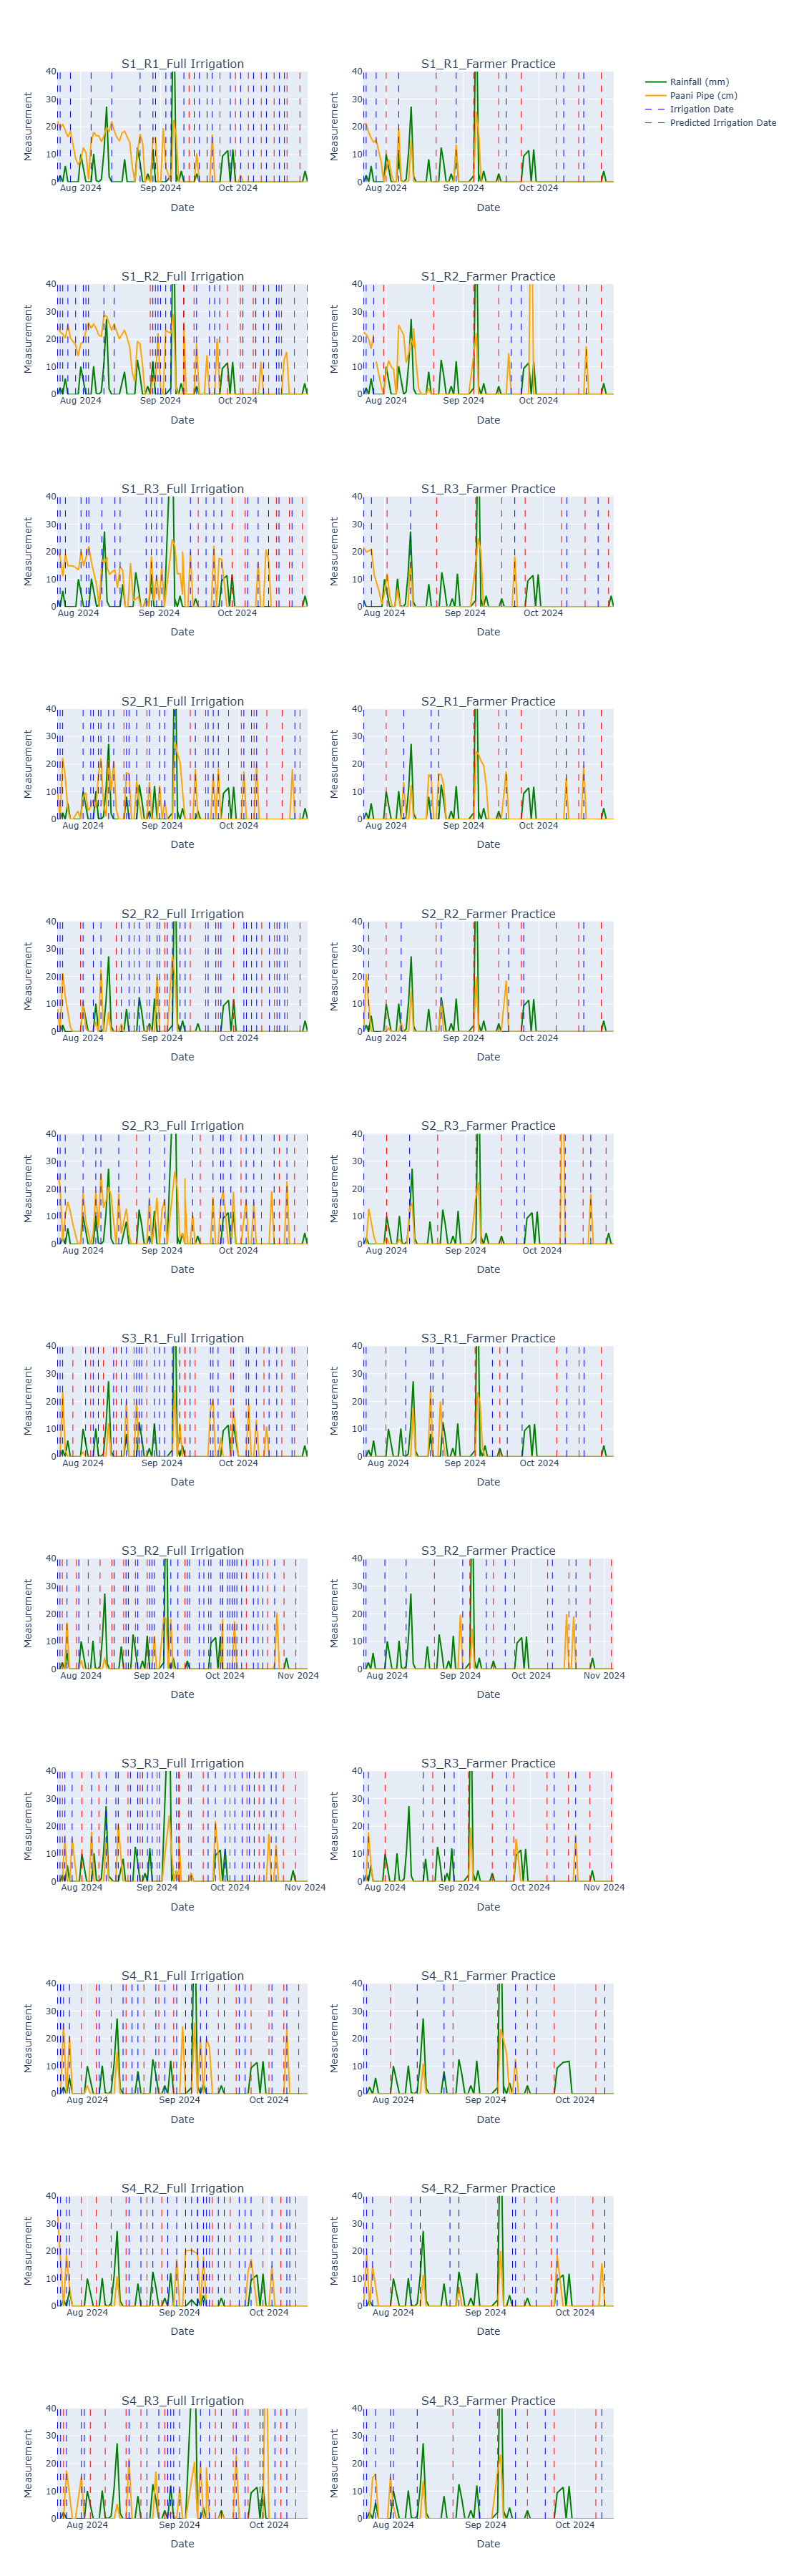

In [13]:
for i, v in enumerate(np.sort(df_far['Recreated_ID'].unique())):
    nd = df_far[df_far['Recreated_ID']== v]
    nd['date'] = pd.to_datetime(nd['date'], format='%Y-%m-%d')
    nd = nd.sort_values(by='date')
    # Check and append irrigation dates
    #nd['irrigation_date'] = nd['irrigation_date'].where(nd['date'] <= nd['irrigation_date'].min(), np.nan)
    nd['irrigation_date'].where(nd['irrigation_date'] >= nd['date'], np.nan)
    irrigation_dates = nd['irrigation_date']
    #print(irrigation_datesf)
    df_predicted = farmer_irrigation(nd)
    df_predicted['predicted_irrigation_date'] = 1
    
    
    if not df_predicted.empty :
        if (df_predicted['date'].iloc[-1] >= nd['date'].max()):
            
            scenario_value = nd['A.Scenario'].unique()
            replication_value = nd['A.Replication_no'].unique()
            hydrology_value =nd['hydrology'].unique()  # Replace with actual hydrology data

            # Create a new row as a dictionary
            new_row = {'Scenario': scenario_value, 'Replication': replication_value, 'Hydrology': hydrology_value}
            data_list.append(new_row)
            # Append the new row to the DataFrame
            #irri_msg = pd.concat([irri_msg, pd.DataFrame(data_list)], ignore_index=True)

            
    # Merge both DataFrames
    df_combined = pd.merge(nd, df_predicted, on='date', how='left')
    df_combined['irrigation_id'] = df_combined['irrigation_date'].apply(lambda x: 1 if pd.notnull(x) else 0)

    row = i+1
    col = 2
    
    #print(row)
    #row = (int(v )- 1) // cols + 1
    #col = (int(v) - 1) % cols + 1

   
    
    fig.add_trace(go.Scatter(x=df_combined['date'], y=df_combined['rainfall'],
                             mode='lines', name='Rainfall (mm)', showlegend=False, line=dict(color='green')), row=row, col=col)
    fig.add_trace(go.Scatter(x=df_combined['date'], y=df_combined['paani_pipe'],
                             mode='lines', name='Paani Pipe (cm)',showlegend=False, line=dict(color='orange')), row=row, col=col)
    
    # Add vertical lines for irrigation dates
    for date in df_combined[df_combined['irrigation_id'] == 1]['date']:
        fig.add_vline(x=date, row = row, col =col, line=dict(color='blue', width=1, dash='dash'), name='Irrigation Date')
    
    # Add vertical lines for predicted irrigation dates
    for date in df_combined[df_combined['predicted_irrigation_date'] == 1]['date']:
        fig.add_vline(x=date, row=row, col=col, line=dict(color='red', width=1, dash='dash'), name='Recommended Irrigation Date')
    
    # Update layout with the same axis titles
    fig.update_xaxes(title_text='Date', row=row, col=col)
    fig.update_yaxes(title_text='Measurement', row=row, col=col)
    fig.update_yaxes(range = [0,40])

# Add dummy traces for the legend
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green'), name='Rainfall (mm)'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='orange'), name='Paani Pipe (cm)'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='blue', width=1, dash='dash'), name='Irrigation Date'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', width=1, dash='dash'), name='Predicted Irrigation Date'))
 
#fig.update_xaxes(rangeslider_visible=True)
        
# Update layout
fig.update_layout(
    height=fig_height, 
    width=fig_width, 
    #title='Rainfall, Paani Pipe, and Irrigation Dates',
    #xaxis_title='Date',
    #yaxis_title='Measurement',
    xaxis=dict(title="Date"),
    yaxis=dict(title="Measurement"),
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05  # Position the legend outside the plot
    ),

)



In [14]:
# Replace with your email credentials and SMTP server details
irri_msg = pd.concat([irri_msg, pd.DataFrame(data_list)], ignore_index=True)   
sender_email = "sis.patna23@gmail.com"
receiver_emails = ["h.rajan@cgiar.org",  "s.poonia@cgiar.org", "s.sherpa@cgiar.org", "rajesh.kumar@cgiar.org"]
subject = "Urgent: Irrigate fields"
smtp_server = 'smtp.gmail.com'
smtp_port = 587
username = "sis.patna23@gmail.com"
password = "ndxw faif awkg ovnv"

send_dataframe_as_email(irri_msg, sender_email, receiver_emails, subject, smtp_server, smtp_port, username, password)
#pio.write_html(fig, file='rainfall_paani_pipe_irrigation_dates.html', auto_open=True)


In [15]:
import datetime
from pytz import timezone

# Create a UTC-aware datetime object directly
utc_now = datetime.datetime.now(datetime.timezone.utc)

# Convert to IST and format for printing
ist_now = utc_now.astimezone(timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S')

print(f'Last updated: {ist_now}')

Last updated: 2025-06-04 12:47:14
